# Using pyAerial for channel estimation on Aerial Data Lake data
This example shows how to use the pyAerial bindings to run cuPHY GPU accelerated channel estimation for 5G NR PUSCH. 5G NR PUSCH data is read from an example over the air captured PUSCH dataset collected and stored using Aerial Data Lake, and the channel is estimated using pyAerial and cuPHY based on the corresponding PUSCH parameters.

**Note:** This example requires that the clickhouse server is running and that the example data has been stored in the database. Refer to the Aerial Data Lake documentation on how to do this.

In [1]:
# Check platform.
import platform
if platform.machine() not in ['x86_64', 'aarch64']:
    raise SystemExit("Unsupported platform!")

## Imports

In [2]:
import math
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Connecting to clickhouse on remote server
import clickhouse_connect

# Import the channel estimator and some utilities for converting
# the DMRS fields in the right format from the SCF FAPI format that the dataset follows.
from aerial.phy5g.algorithms import ChannelEstimator
from aerial.util.fapi import dmrs_fapi_to_bit_array

## Data
We use an example dataset which has been captured from a real over the air PUSCH transmission. 
The "fapi" table in the database contains the metadata for each PUSCH transmission and the "fh" table contains all of the samples for that slot. 

In [3]:
# Create the pyAerial (cuPHY) channel estimator.
num_ues = 1
num_rx_ant = 1
channel_estimator = ChannelEstimator(num_rx_ant=num_rx_ant)

# Connect to the local database
client = clickhouse_connect.get_client(host='localhost')

## Run channel estimation
From the PUSCH record we extract the PUSCH DMRS parameters and use the TAI time entry to select the IQ samples for that slot
Channel estimation is then run using the extracted parameters, and the absolute values of the estimated channels are plotted in the same figure.

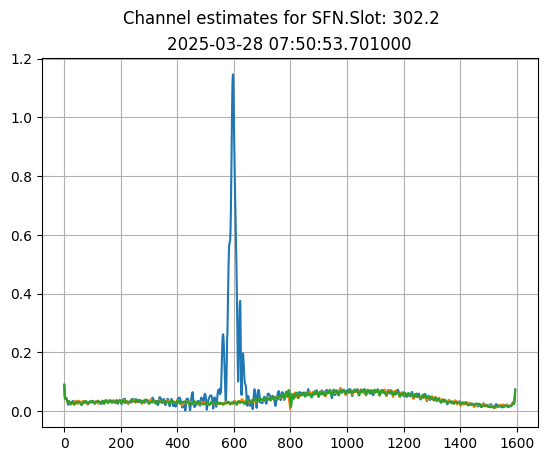

KeyboardInterrupt: 

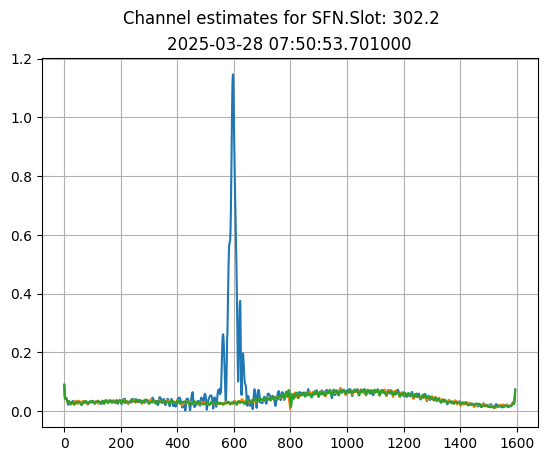

In [4]:
import time
from IPython.display import display, clear_output

plt.ion()  # Turn on interactive mode
fig, axs = plt.subplots()

while True:
    # Pick some pusch records from the database
    pusch_records = client.query_df('select * from fapi order by TsTaiNs desc limit 1')
    
    for index,pusch_record in pusch_records.iterrows():
        query = f"""select TsTaiNs,fhData from fh where 
                TsTaiNs == {pusch_record.TsTaiNs.timestamp()}
                """
    
        fh = client.query_df(query)
        
        # Make sure that the fronthaul database is complete for the SFN.Slot we've chosen
        if fh.index.size < 1:
            pusch_records = pusch_records.drop(index)
            continue;
    
        fh_samp = np.array(fh['fhData'][0], dtype=np.float32)
        rx_slot = np.swapaxes(fh_samp.view(np.complex64).reshape(4, 14, 273*12),2,0)
    
        # Extract all the needed parameters from the PUSCH record.
        slot = int(pusch_record.Slot)
        rntis = [pusch_record.rnti]
        layers = [pusch_record.nrOfLayers]
        start_prb = pusch_record.rbStart
        num_prbs = pusch_record.rbSize
        start_sym = pusch_record.StartSymbolIndex
        num_symbols = pusch_record.NrOfSymbols
        scids = [int(pusch_record.SCID)]
        data_scids = [pusch_record.dataScramblingId]
        dmrs_scrm_id = pusch_record.ulDmrsScramblingId
        num_dmrs_cdm_grps_no_data = pusch_record.numDmrsCdmGrpsNoData
        dmrs_syms = dmrs_fapi_to_bit_array(int(pusch_record.ulDmrsSymbPos))
        dmrs_ports = [pusch_record.dmrsPorts]
        dmrs_max_len = 1
        dmrs_add_ln_pos = 2
        num_subcarriers = num_prbs * 12
        mcs_tables = [pusch_record.mcsTable]
        mcs_indices = [pusch_record.mcsIndex]
        coderates = [pusch_record.targetCodeRate/10.]
        tb_sizes = [pusch_record.TBSize]
        mod_orders = [pusch_record.qamModOrder]
        tb_input = np.array(pusch_record.pduData)
    
        # Run PyAerial (cuPHY) channel estimation.
        ch_est = channel_estimator.estimate(
            rx_slot=rx_slot,
            num_ues=num_ues,
            layers=layers,            
            scids=scids,
            slot=slot,
            dmrs_ports=dmrs_ports,            
            dmrs_syms=dmrs_syms,
            dmrs_scrm_id=dmrs_scrm_id,
            dmrs_max_len=dmrs_max_len,
            dmrs_add_ln_pos=dmrs_add_ln_pos,
            num_dmrs_cdm_grps_no_data=num_dmrs_cdm_grps_no_data,          
            start_prb=start_prb,
            num_prbs=num_prbs,
            prg_size=1,
            num_ul_streams=1,
            start_sym=start_sym,
            num_symbols=num_symbols
        )

        axs.clear()  # Clear previous plot
        fig.suptitle("Channel estimates for SFN.Slot: "+str(pusch_record.SFN)+"."+str(pusch_record.Slot))
        axs.set_title(pusch_record.TsTaiNs)
        for idx in range(int(sum(dmrs_syms))):
            axs.plot(np.abs(ch_est[0][0, 0, :, idx]))
        axs.grid(True)

        clear_output(wait=True)  # Clear the output to prevent duplicate images
        display(fig)  # Redisplay the updated figure

        time.sleep(0.001)